# Implement Tranfer-Learning

We wish to learn to seperate images of classic cars vs modern cars

This requires training a large CNN - which is highly time consuming (even on a GPU), and requires huge amounts of data

Most of the network barring last layer is all about learning suitable features.

For feature engineering we piggyback on a pre-trained network : we use Google's inception model




## Approach:

We extract a vector representation of a set of images using the GoogLeNet CNN pretrained on ImageNet. 

Then build a 'simple SVM classifier', allowing new images can be classified directly. 

No retraining of the original CNN is required.

We are just training the SVM

In [1]:
import tensorflow as tf

import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import time

#from urllib.request import urlopen  # Python 3+ version (instead of urllib2)
from urllib2 import urlopen

CLASS_DIR='./images/cars'

In [2]:
# Get hold of Google's model zoo

import os, sys

slim_models_dir = './models/tensorflow_zoo'

if not os.path.exists(slim_models_dir):
    print("Creating model/tensorflow_zoo directory")
    os.makedirs(slim_models_dir)
    
if not os.path.isfile( os.path.join(slim_models_dir, 'models', 'README.md') ):
    print("Cloning tensorflow model zoo under %s" % (slim_models_dir, ))
    !cd {slim_models_dir}; git clone https://github.com/tensorflow/models.git

sys.path.append(slim_models_dir + "/models/research/slim")

print("Model Zoo model code installed")

Model Zoo model code installed


### Inception is trained on image-net


![Image net](https://image.slidesharecdn.com/dlcvd2l4imagenet-160802094728/95/deep-learning-for-computer-vision-imagenet-challenge-upc-2016-4-638.jpg "Image net")

Inception : Google's model to attack this problem

Called "Inception" becuase it has network within network


![Inception](https://4.bp.blogspot.com/-TMOLlkJBxms/Vt3HQXpE2cI/AAAAAAAAA8E/7X7XRFOY6Xo/s1600/image03.pngg "Inception model")

It has ~150 layers with 23 million paramters !

In [8]:
import keras

m = keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None)

Using TensorFlow backend.
/home/root1/.virtualenv/demos/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 149, 149, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 149, 149, 32)  96                                           
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 149, 149, 32)  0                                            
___________________________________________________________________________________________

#  Download the Inception V1 checkpoint

Functions for building the GoogLeNet model with TensorFlow / slim and preprocessing the images are defined in model.inception_v1_tf - which was downloaded from the TensorFlow / slim Model Zoo.


In [3]:
# get hold of v1 checkpoint of inception model

from datasets import dataset_utils

targz = "inception_v1_2016_08_28.tar.gz"
url = "http://download.tensorflow.org/models/"+targz
checkpoints_dir = './data/tensorflow_zoo/checkpoints'

if not os.path.exists(checkpoints_dir):
    os.makedirs(checkpoints_dir)

if not os.path.isfile( os.path.join(checkpoints_dir, 'inception_v1.ckpt') ):
    tarfilepath = os.path.join(checkpoints_dir, targz)
    if os.path.isfile(tarfilepath):
        import tarfile
        tarfile.open(tarfilepath, 'r:gz').extractall(checkpoints_dir)
    else:
        dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)
        
    # Get rid of tarfile source (the checkpoint itself will remain)
    os.unlink(tarfilepath)
        
print("Checkpoint available locally")

Checkpoint available locally


### Build the model and select layers we need - the features are taken from the final network layer, before the softmax nonlinearity.

In [4]:
slim = tf.contrib.slim

from nets import inception
from preprocessing import inception_preprocessing

image_size = inception.inception_v1.default_image_size
image_size

224

In [10]:
# Get hold of labeled image net dataset 

imagenet_labels_file = './data/imagenet_synset_words.txt'

if os.path.isfile(imagenet_labels_file):
    print("Loading ImageNet synset data locally")
    with open(imagenet_labels_file, 'r') as f:
        imagenet_labels = {0: 'background'}
        for i, line in enumerate(f.readlines()):
            # n01440764 tench, Tinca tinca
            synset,human = line.strip().split(' ', 1)
            imagenet_labels[ i+1 ] = human

else:
    print("Downloading ImageNet synset data from repo")
    from datasets import imagenet
    imagenet_labels = imagenet.create_readable_names_for_imagenet_labels()
    
print("ImageNet synset labels available")

ImageNet synset labels available


In [6]:
tf.reset_default_graph()

# This creates an image 'placeholder'
# input_image = tf.image.decode_jpeg(image_string, channels=3)    
input_image = tf.placeholder(tf.uint8, shape=[None, None, 3], name='input_image')

# Define the pre-processing chain within the graph - based on the input 'image' above
processed_image = inception_preprocessing.preprocess_image(input_image, image_size, image_size, is_training=False)
processed_images = tf.expand_dims(processed_image, 0)

# Reverse out some of the transforms, so we can see the area/scaling of the inception input
numpyish_image = tf.multiply(processed_image, 0.5)
numpyish_image = tf.add(numpyish_image, 0.5)
numpyish_image = tf.multiply(numpyish_image, 255.0)

# Create the model - which uses the above pre-processing on image
#   it also uses the default arg scope to configure the batch norm parameters.
print("Model builder starting")

# Here is the actual model zoo model being instantiated :
with slim.arg_scope(inception.inception_v1_arg_scope()):
    logits, _ = inception.inception_v1(processed_images, num_classes=1001, is_training=False)
probabilities = tf.nn.softmax(logits)

# Create an operation that loads the pre-trained model from the checkpoint
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
    slim.get_model_variables('InceptionV1')
)

print("Model defined")

Model builder starting
Model defined


In [11]:
'''

if False:
    # Read from the Web
    from io import BytesIO 
    url = 'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
    image_string = urlopen(url).read()
    im = plt.imread(BytesIO(image_string), format='jpg')

if False:
    # Read from a file via a queue ==> brain damage in jupyter
    
    #filename_queue = tf.train.string_input_producer( tf.train.match_filenames_once("./images/*.jpg") )
    filename_queue = tf.train.string_input_producer( ['./images/cat-with-tongue_224x224.jpg'] )
    #_ = filename_queue.dequeue()  # Ditch the first value
    
    image_reader = tf.WholeFileReader()
    
    _, image_string = image_reader.read(filename_queue)

'''


In [13]:
# Read from a file
im = plt.imread("./images/cat-with-tongue_224x224.jpg")
print(im.shape, im[0,0])

((2250, 1728, 3), array([137, 167, 191], dtype=uint8))


In [14]:
def crop_middle_square_area(np_image):
    h, w, _ = np_image.shape
    h = int(h/2)
    w = int(w/2)
    if h>w:
        return np_image[ h-w:h+w, : ]
    return np_image[ :, w-h:w+h ]    
im_sq = crop_middle_square_area(im)
im_sq.shape

(1728, 1728, 3)

INFO:tensorflow:Restoring parameters from ./data/tensorflow_zoo/checkpoints/inception_v1.ckpt


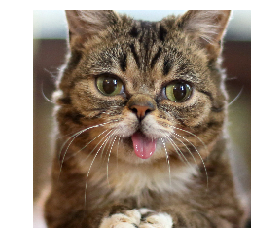

Probability 0.54% => [tabby, tabby cat]
Probability 0.23% => [tiger cat]
Probability 0.08% => [Egyptian cat]
Probability 0.02% => [Persian cat]
Probability 0.01% => [lynx, catamount]


In [15]:
# Now let's run the pre-trained model
with tf.Session() as sess:
    # This is the loader 'op' we defined above
    init_fn(sess)  
    
    # This is two ops : one merely loads the image from numpy, 
    #   the other runs the network to get the class probabilities
    np_image, np_probs = sess.run([numpyish_image, probabilities], feed_dict={input_image:im_sq})
        
# These are regular numpy operations
probs = np_probs[0, :]
sorted_inds = [i[0] for i in sorted(enumerate(-probs), key=lambda x:x[1])]

# And now plot out the results
plt.figure()
plt.imshow(np_image.astype(np.uint8))
plt.axis('off')
plt.show()

for i in range(5):
    index = sorted_inds[i]
    print('Probability %0.2f%% => [%s]' % (probs[index], imagenet_labels[index]))

In [16]:
import os
classes = sorted( [ d for d in os.listdir(CLASS_DIR) if os.path.isdir("%s/%s" % (CLASS_DIR, d)) ] )
classes # Sorted for for consistency

['Classic', 'Modern']

INFO:tensorflow:Restoring parameters from ./data/tensorflow_zoo/checkpoints/inception_v1.ckpt
Loaded pre-trained model
DONE :   0.68 seconds each


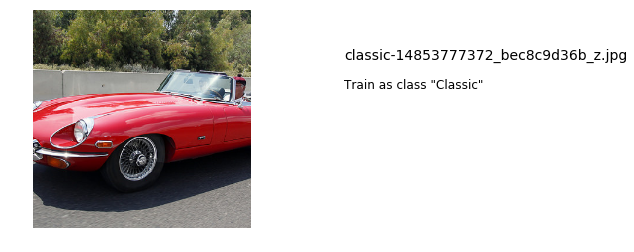

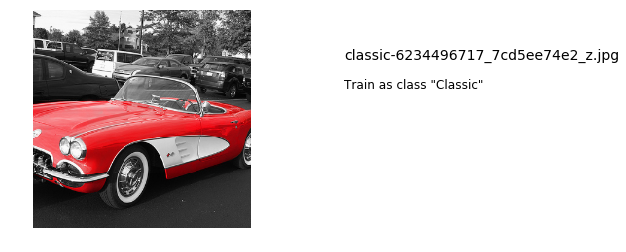

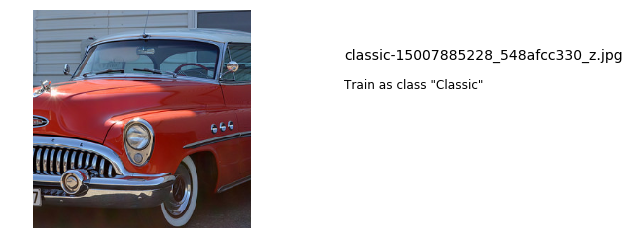

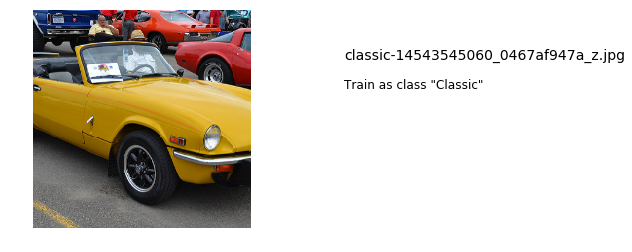

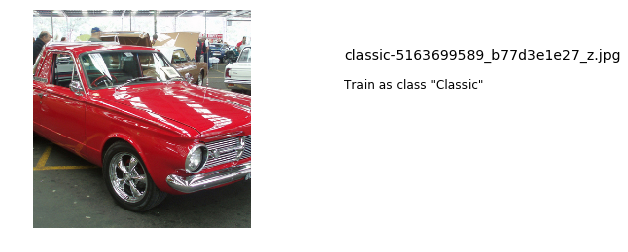

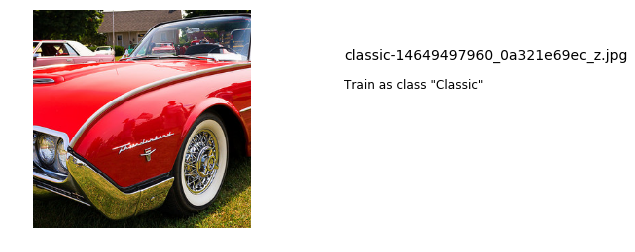

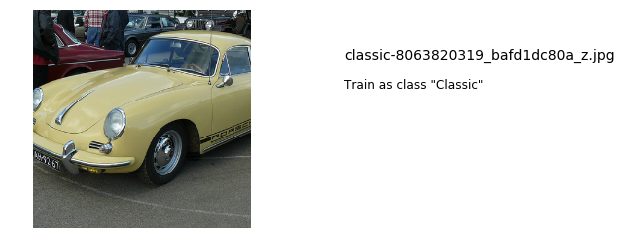

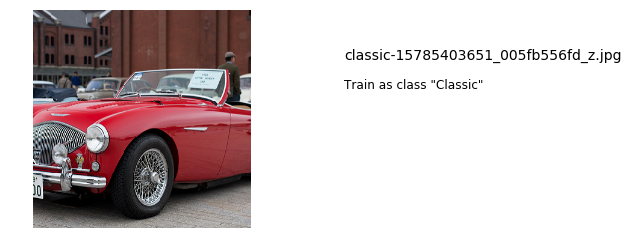

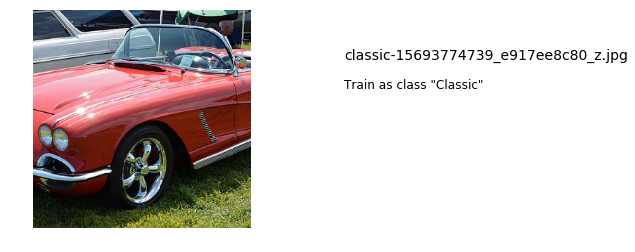

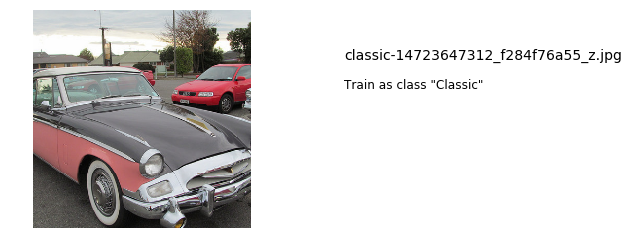

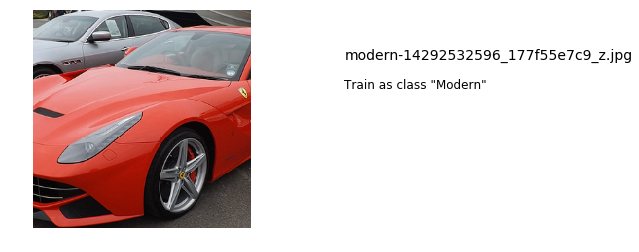

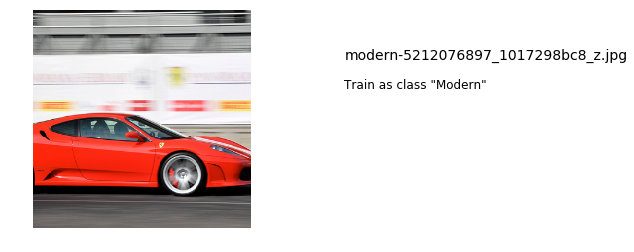

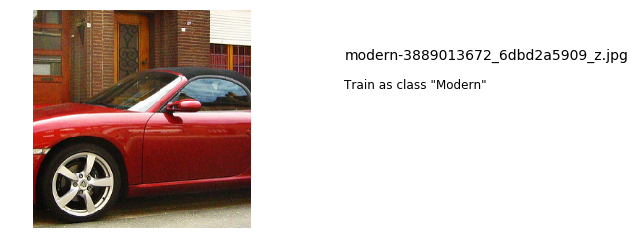

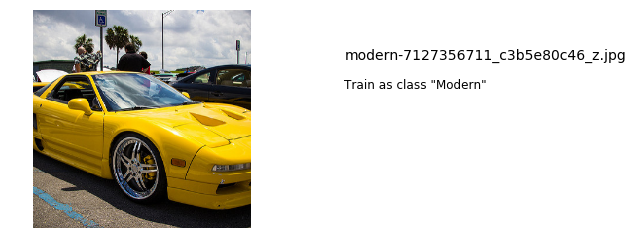

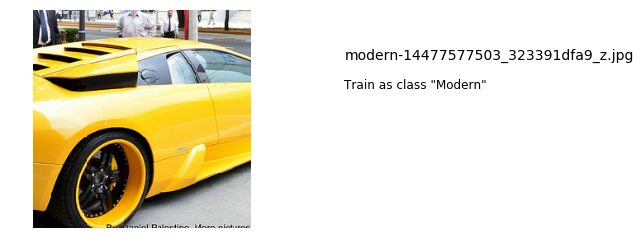

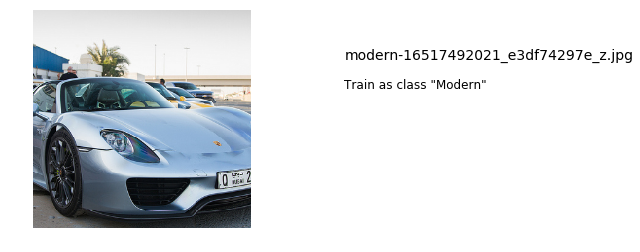

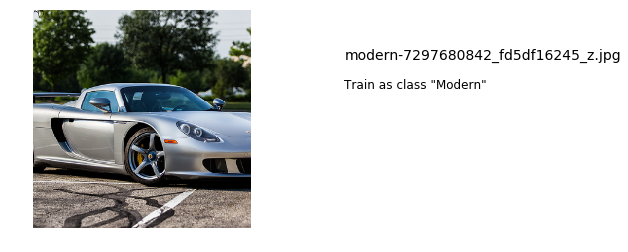

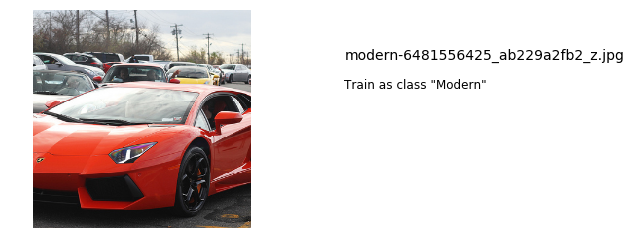

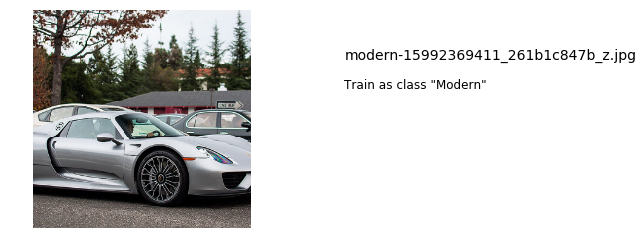

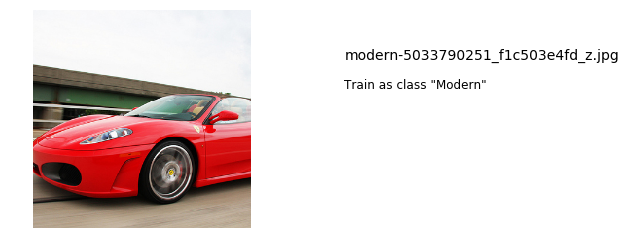

In [17]:
train = dict(filepath=[], features=[], target=[])

with tf.Session() as sess:
    # This is the loader 'op' we defined above
    init_fn(sess)  
    print("Loaded pre-trained model")
    
    t0 = time.time()
    
    for class_i, directory in enumerate(classes):
        for filename in os.listdir("%s/%s" % (CLASS_DIR, directory, )):
            filepath = '%s/%s/%s' % (CLASS_DIR, directory, filename, )
            if os.path.isdir(filepath): continue
                
            im = plt.imread(filepath)
            im_sq = crop_middle_square_area(im)

            # This is two ops : one merely loads the image from numpy, 
            #   the other runs the network to get the 'logit features'
            rawim, np_logits = sess.run([numpyish_image, logits], feed_dict={input_image:im_sq})
    
            train['filepath'].append(filepath)
            train['features'].append(np_logits[0])
            train['target'].append( class_i )

            plt.figure()
            plt.imshow(rawim.astype('uint8'))
            plt.axis('off')

            plt.text(320, 50, '{}'.format(filename), fontsize=14)
            plt.text(320, 80, 'Train as class "{}"'.format(directory), fontsize=12)
    
print("DONE : %6.2f seconds each" %(float(time.time() - t0)/len(train),))

In [18]:
print train.keys()

print len(train['features'])
print len(train['target'])
print len(train['filepath'])

print train['features'][0].shape
#print train['features'][0][0]

print train['target'][0]

print train['filepath'][0]

['features', 'target', 'filepath']
20
20
20
(1001,)
0
./images/cars/Classic/classic-14853777372_bec8c9d36b_z.jpg


# Build an SVM model over the features

In [20]:
# train['features'][0]

(1001,)

In [21]:
from sklearn import svm
classifier = svm.LinearSVC()
classifier.fit(train['features'], train['target']) # learn from the data

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [22]:
# Use the SVM model to classify the test set

INFO:tensorflow:Restoring parameters from ./data/tensorflow_zoo/checkpoints/inception_v1.ckpt
Loaded pre-trained model
DONE :   0.11 seconds each


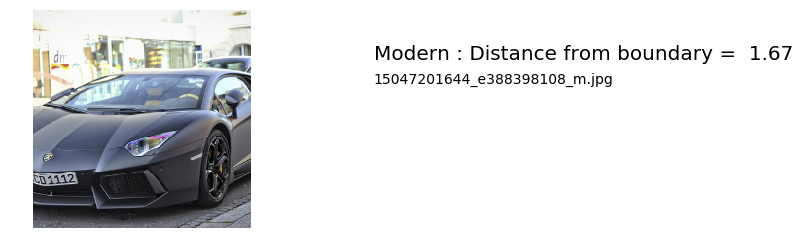

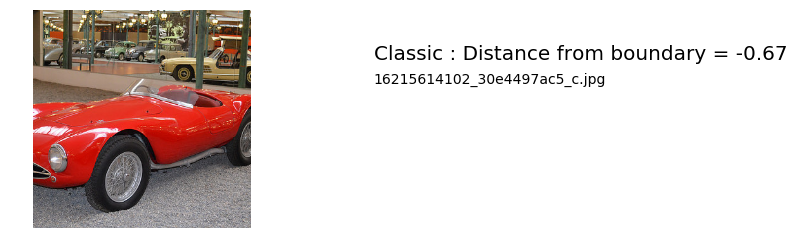

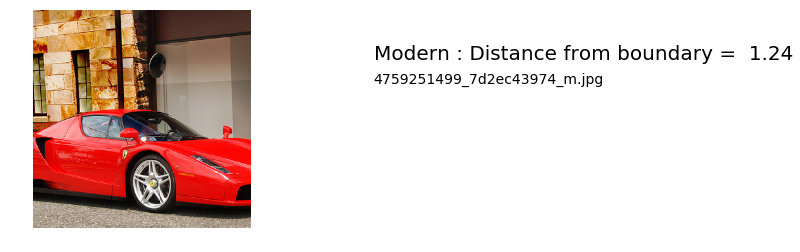

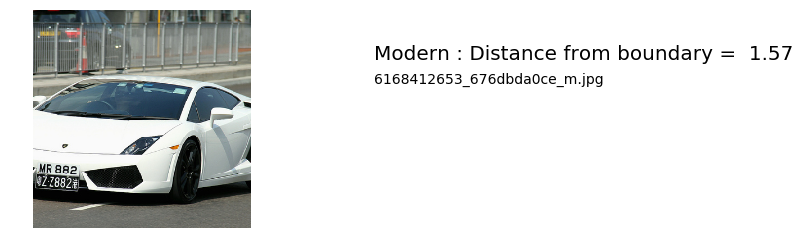

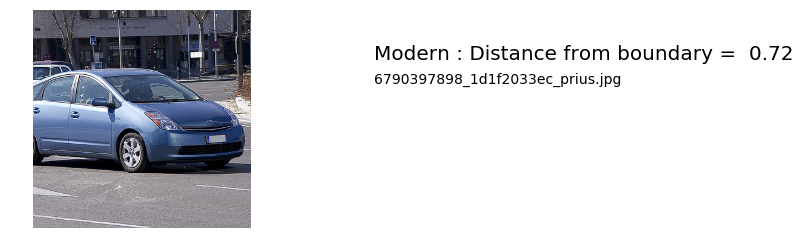

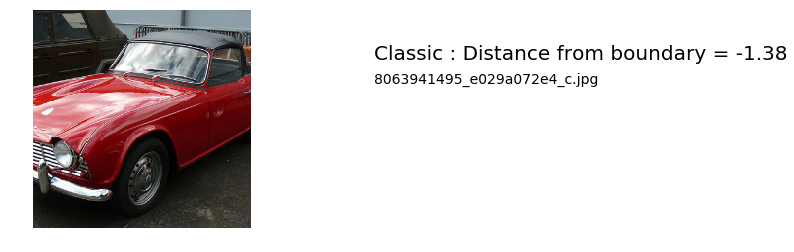

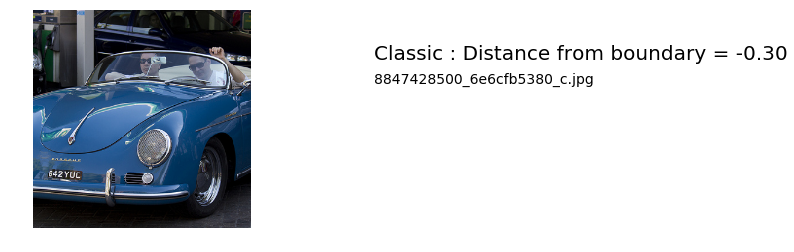

In [23]:
test_image_files = [f for f in os.listdir(CLASS_DIR) if not os.path.isdir("%s/%s" % (CLASS_DIR, f))]

with tf.Session() as sess:
    # This is the loader 'op' we defined above
    init_fn(sess)  
    print("Loaded pre-trained model")
    
    t0 = time.time()
    for filename in sorted(test_image_files):
        im = plt.imread('%s/%s' % (CLASS_DIR,filename,))
        im_sq = crop_middle_square_area(im)

        # This is two ops : one merely loads the image from numpy, 
        #   the other runs the network to get the class probabilities
        rawim, np_logits = sess.run([numpyish_image, logits], feed_dict={input_image:im_sq})

        prediction_i = classifier.predict([ np_logits[0] ])
        decision     = classifier.decision_function([ np_logits[0] ])

        plt.figure()
        plt.imshow(rawim.astype('uint8'))
        plt.axis('off')

        prediction = classes[ prediction_i[0] ]

        plt.text(350, 50, '{} : Distance from boundary = {:5.2f}'.format(prediction, decision[0]), fontsize=20)
        plt.text(350, 75, '{}'.format(filename), fontsize=14)
    
print("DONE : %6.2f seconds each" %(float(time.time() - t0)/len(test_image_files),))